In [150]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
from math import ceil

from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix

In [2]:
data = pd.read_csv('data/train.csv',
                       encoding = "ISO-8859-1",
                       sep=';',
                       skiprows=1,
                       names=['Дата','Количество поступивших вызовов',
                              'Количество принятых вызовов','Количество потерянных вызовов',
                              'Ср. скорость ответа оператора (сек.)','Ср. время разговора (сек.)',
                              'Ср. число операторов','Макс. число операторов'])
print(data.shape)

target = pd.read_csv('data/submission_sample.csv',
                       encoding = "ISO-8859-1",
                       sep=';',
                       skiprows=1,
                       names=['Дата','Количество поступивших вызовов'])
print(target.shape)

data['Дата'] = pd.to_datetime(data['Дата'], format='%d.%m.%Y')
target['Дата'] = pd.to_datetime(target['Дата'], format='%d.%m.%Y')

print(data['Дата'].dtype)
print(target['Дата'].dtype)

(549, 8)
(61, 2)
datetime64[ns]
datetime64[ns]


In [274]:
df = pd.DataFrame()
df[['date', 'target']] = data[['Дата','Количество поступивших вызовов']]

In [275]:
def get_parsed_data(time):
    parsed = time
    return parsed.year, parsed.month, parsed.day, parsed.weekday() #, parsed.minute, parsed.second

df['year'], df['month'], df['day'], df['weekday'] = \
    zip(*df.date.apply(get_parsed_data))

In [276]:
def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

df['week_of_month'] = df.date.apply(week_of_month)

In [277]:
def is_in_13_19(dt):
    day = dt.day
    if day in [13,14,15,16,17,18,19]:
        return 1
    return 0

def is_in_16_18(dt):
    day = dt.day
    if day in [14,15,16,17]:
        return 1
    return 0

df['13_19'] = df.date.apply(is_in_13_19)
df['16_18'] = df.date.apply(is_in_16_18)

In [278]:
temp_df = df.groupby(['year','month', 'week_of_month']).agg({'week_of_month': 'count'})
vals = temp_df.values
temp_df['days_in_week'] = vals
del temp_df['week_of_month']
temp_df.head()

days_in_week
year month week_of_month              
2017 3     1                         5
           2                         7
           3                         7
           4                         7
           5                         5

In [279]:
df = df.join(temp_df, how='left', on=['year','month', 'week_of_month'])

In [280]:
short_1st_week_arr = np.zeros(df.shape[0])

def short_1st_week(y, m):
    first_week = df[(df.year == y) &
                   (df.month == m) &
                   (df['week_of_month'] == 1)]
    if first_week.days_in_week.head(1).values < 5:
        return 1
    return 0

for row in range(df.shape[0]):
    y = df.iloc[row].year
    m = df.iloc[row].month    
    short_1st_week_arr[row] = short_1st_week(y, m)
            

df['short_1st_week'] = short_1st_week_arr

In [281]:
df.week_of_month = df.week_of_month - df.short_1st_week

In [282]:
df['weekday_week_of_month'] =  df['weekday'].astype(str) + '_' + df['week_of_month'].astype(str)

In [283]:
attention = np.zeros(df.shape[0])
df['attention'] = attention

for row in range(df.shape[0]):
    if df.iloc[row].target > 3500:
        attention[row] = 1
        if df.iloc[row-1].weekday != 6 and attention[row-1] != 1:            
            attention[row-1] = 1
        if df.iloc[row+1].weekday != 5 and attention[row+1] != 1:
            attention[row+1] = 1
df['attention'] = attention

In [284]:
features = ['month','day','weekday','week_of_month',
            '13_19',
#             'attention',
            'weekday_week_of_month',
            '16_18',
#             'short_1st_week'
           ]

target = 'target'

In [285]:
df[df.target > 3500]

,date,target,year,month,day,weekday,week_of_month,13_19,16_18,days_in_week,short_1st_week,weekday_week_of_month,attention
48,2017-04-18,3954,2017,4,18,1,3.0,1,0,7,1.0,1_3.0,1.0
77,2017-05-17,3579,2017,5,17,2,3.0,1,1,7,0.0,2_3.0,1.0
78,2017-05-18,3792,2017,5,18,3,3.0,1,0,7,0.0,3_3.0,1.0
79,2017-05-19,3750,2017,5,19,4,3.0,1,0,7,0.0,4_3.0,1.0
110,2017-06-19,5134,2017,6,19,0,3.0,1,0,7,1.0,0_3.0,1.0
111,2017-06-20,4218,2017,6,20,1,3.0,0,0,7,1.0,1_3.0,1.0
112,2017-06-21,3573,2017,6,21,2,3.0,0,0,7,1.0,2_3.0,1.0
230,2017-10-17,4278,2017,10,17,1,3.0,1,1,7,1.0,1_3.0,1.0
321,2018-01-16,3532,2018,1,16,1,3.0,1,1,7,0.0,1_3.0,1.0
352,2018-02-16,5374,2018,2,16,4,2.0,1,1,7,1.0,4_2.0,1.0


### Baseline

In [286]:
df['target_shift_year'] = df['target'].shift(364)

In [287]:
print( mean_absolute_error(y_true=df.target[364:], y_pred=df.target_shift_year[364:]) )

345.03783783783786


### ML

In [297]:
df[features].head(250).tail(5)

,month,day,weekday,week_of_month,13_19,weekday_week_of_month,16_18
245,11,1,2,1.0,0,2_1.0,0
246,11,2,3,1.0,0,3_1.0,0
247,11,3,4,1.0,0,4_1.0,0
248,11,4,5,1.0,0,5_1.0,0
249,11,5,6,1.0,0,6_1.0,0


In [153]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostRegressor, CatBoostClassifier
import lightgbm

In [289]:
cat_parameters = {'n_estimators':[50, 20],
                  'max_depth':[10, 5, 2],
                  'learning_rate':[.5, 1],
                  'loss_function':['RMSE']}

cat_model = CatBoostRegressor(random_state=42,
                             verbose=-1)

ct_gscv = GridSearchCV(cat_model, cat_parameters, cv=5, scoring='neg_mean_absolute_error')
ct_gscv.fit(df[features], df[target])

/home/innodata/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=<catboost.core.CatBoostRegressor object at 0x7fcfa5368d30>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 20], 'max_depth': [10, 5, 2], 'learning_rate': [0.5, 1], 'loss_function': ['RMSE']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [290]:
print(- ct_gscv.best_score_)
print(ct_gscv.cv_results_['mean_train_score'])
print(ct_gscv.cv_results_['mean_test_score'])
print(ct_gscv.best_params_)
print()
print('Feature importances')
pd.DataFrame(ct_gscv.best_estimator_.feature_importances_,
             ct_gscv.best_estimator_.feature_names_).sort_values(0, ascending=False).head(10)

258.8880285772704
[-179.82609956 -226.6710596  -198.5570592  -229.0565368  -225.69154079
 -242.29750959 -157.09691143 -203.24273328 -193.59235444 -220.15628628
 -226.65087605 -244.82094672]
[-282.9100946  -274.78712785 -266.41829991 -258.88802858 -266.09090419
 -265.3558727  -311.99026231 -292.16258582 -300.35506272 -294.19905842
 -279.02452206 -289.2886406 ]
{'learning_rate': 0.5, 'loss_function': 'RMSE', 'max_depth': 5, 'n_estimators': 20}

Feature importances


/home/innodata/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,0
weekday,60.092567
13_19,16.523185
day,7.818607
month,5.404182
week_of_month,5.379374
weekday_week_of_month,3.877972
16_18,0.904114


In [291]:
X_train = df[features][:185].append(df[features][245:])
y_train = df.target[:185].append(df[target][245:])
X_test = df[features][185:245]
# att_test = X_test['attention']
y_test = df.target[185:245]

# rf = CatBoostClassifier(verbose=-1, n_estimators=10)
# rf.fit(X_train[[f for f in features if f != 'attention']], X_train['attention'])
# att_pred = rf.predict(X_test[[f for f in features if f != 'attention']])

# print(confusion_matrix(y_true=att_test, y_pred=att_pred))
# print(classification_report(y_true=att_test, y_pred=att_pred))

162.69012230041892


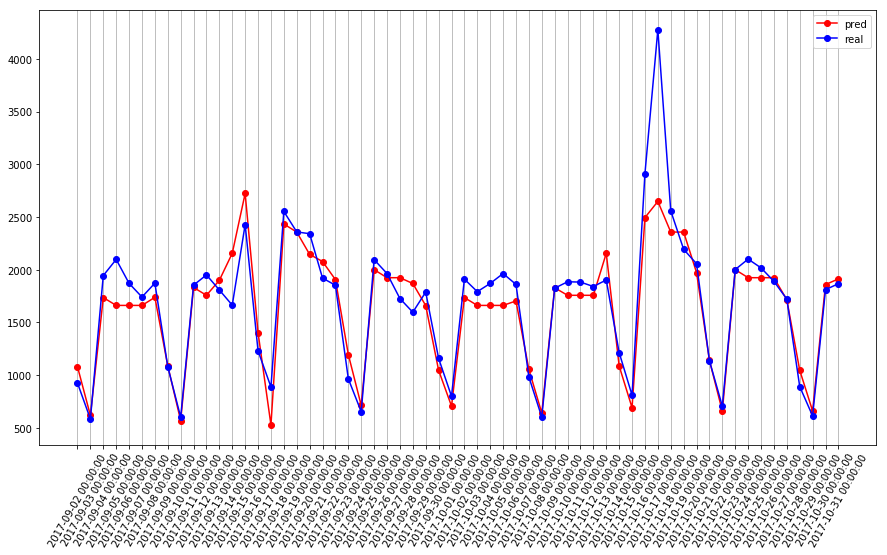

In [296]:
# X_train, X_test, y_train, y_test = train_test_split( df[features], df[target], test_size=0.2)

cat = CatBoostRegressor(loss_function='RMSE', max_depth=3, n_estimators=50, learning_rate=0.5, verbose=-1)
cat.fit(X_train, y_train)

pred = cat.predict(X_test)
real = y_test.values

print(mean_absolute_error(real, pred))
plt.figure(figsize=(15,8))
plt.plot(pred, 'r-o', label='pred')
plt.plot(real, 'b-o', label='real')
# plt.plot(np.abs(pred-real), 'g-o')
plt.xticks(np.arange(60),  df['date'][185:245], rotation=60)
plt.gca().xaxis.grid(True)
plt.legend()
plt.show()
